# CODE TO IMPLEMENT A RECOMMENDER SYSTEM

# Problem statement

- This notebook implements a movie recommender system. 
- Recommender systems are used to suggest movies or songs to users based on their interest or usage history. 
- For example, Netflix recommends movies to watch based on the previous movies you've watched.  
- In this example, we will use Item-based Collaborative Filter 



- Dataset MovieLens: https://grouplens.org/datasets/movielens/100k/

# import libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import dataset

In [33]:
#two datasets are available,
#let's load the first one
movie_titles_df = pd.read_csv("Movie_Id_Titles")
movie_titles_df.head(30)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [34]:
#let's load the second one
movie_rating_df = pd.read_csv('u.data', sep = '\t', names = ['user_id', 'item_id', 'rating', 'timestamp'])
movie_rating_df.head(10)

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
5,22,377,1,878887116
6,244,51,2,880606923
7,166,346,1,886397596
8,298,474,4,884182806
9,115,265,2,881171488


In [35]:
movie_rating_df.tail(10)

,user_id,item_id,rating,timestamp
99993,806,421,4,882388897
99994,676,538,4,892685437
99995,721,262,3,877137285
99996,913,209,2,881367150
99997,378,78,3,880056976
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156
100002,12,203,3,879959583


In [36]:
#let's drop the timestamp
movie_rating_df.drop(['timestamp'] , axis = 1, inplace = True)

In [37]:
movie_rating_df

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
...,...,...,...
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2


In [38]:
movie_rating_df.describe()

,user_id,item_id,rating
count,100003.000000,100003.000000,100003.000000
mean,462.470876,425.520914,3.529864
std,266.622454,330.797791,1.125704
min,0.000000,1.000000,1.000000
25%,254.000000,175.000000,3.000000
50%,447.000000,322.000000,4.000000
75%,682.000000,631.000000,4.000000
max,943.000000,1682.000000,5.000000


In [39]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100003 non-null  int64
 1   item_id  100003 non-null  int64
 2   rating   100003 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [40]:
#let's merge both dataframes on item_id 
movie_rating_df = pd.merge(movie_rating_df , movie_titles_df , on = 'item_id')

In [41]:
movie_rating_df

,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
1,290,50,5,Star Wars (1977)
2,79,50,4,Star Wars (1977)
3,2,50,5,Star Wars (1977)
4,8,50,5,Star Wars (1977)
...,...,...,...,...
99998,840,1674,4,Mamma Roma (1962)
99999,655,1640,3,"Eighth Day, The (1996)"
100000,655,1637,3,Girls Town (1996)
100001,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [43]:
movie_rating_df.shape

(100003, 4)

# visualize dataset

In [44]:
movie_rating_df.groupby('title')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


In [45]:
rating_mean_df = movie_rating_df.groupby('title')['rating'].describe()['mean']

In [46]:
rating_mean_df

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: mean, Length: 1664, dtype: float64

In [ ]:
rating_count_df = movie_rating_df.groupby('title')['rating'].describe()['count']

In [16]:
rating_count_df

title
'Til There Was You (1997)                  9.0
1-900 (1994)                               5.0
101 Dalmatians (1996)                    109.0
12 Angry Men (1957)                      125.0
187 (1997)                                41.0
                                         ...  
Young Guns II (1990)                      44.0
Young Poisoner's Handbook, The (1995)     41.0
Zeus and Roxanne (1997)                    6.0
unknown                                    9.0
Á köldum klaka (Cold Fever) (1994)         1.0
Name: count, Length: 1664, dtype: float64

In [17]:
rating_mean_count_df = pd.concat([rating_count_df , rating_mean_df] , axis = 1)

In [18]:
rating_mean_count_df

,count,mean
title,,
'Til There Was You (1997),9.0,2.333333
1-900 (1994),5.0,2.600000
101 Dalmatians (1996),109.0,2.908257
12 Angry Men (1957),125.0,4.344000
187 (1997),41.0,3.024390
...,...,...
Young Guns II (1990),44.0,2.772727
"Young Poisoner's Handbook, The (1995)",41.0,3.341463
Zeus and Roxanne (1997),6.0,2.166667


In [19]:
rating_mean_count_df.reset_index()

,title,count,mean
0,'Til There Was You (1997),9.0,2.333333
1,1-900 (1994),5.0,2.600000
2,101 Dalmatians (1996),109.0,2.908257
3,12 Angry Men (1957),125.0,4.344000
4,187 (1997),41.0,3.024390
...,...,...,...
1659,Young Guns II (1990),44.0,2.772727
1660,"Young Poisoner's Handbook, The (1995)",41.0,3.341463
1661,Zeus and Roxanne (1997),6.0,2.166667
1662,unknown,9.0,3.444444


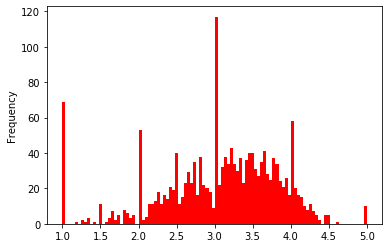

In [20]:
rating_mean_count_df['mean'].plot(bins=100 , kind = 'hist', color='r')

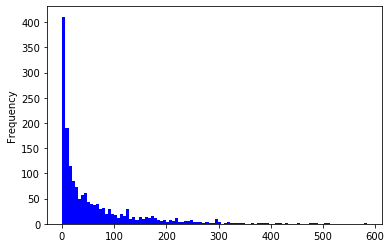

In [21]:
rating_mean_count_df['count'].plot(bins=100, kind= 'hist', color='b')

In [22]:
#let's see the highest rated movies and will have only a few reviews
rating_mean_count_df[rating_mean_count_df['mean']==5]

,count,mean
title,,
Aiqing wansui (1994),1.0,5.0
Entertaining Angels: The Dorothy Day Story (1996),1.0,5.0
"Great Day in Harlem, A (1994)",1.0,5.0
Marlene Dietrich: Shadow and Light (1996),1.0,5.0
Prefontaine (1997),3.0,5.0
"Saint of Fort Washington, The (1993)",2.0,5.0
Santa with Muscles (1996),2.0,5.0
Someone Else's America (1995),1.0,5.0
Star Kid (1997),3.0,5.0


In [23]:
#let's us see the most rated movies
rating_mean_count_df.sort_values('count', ascending= False).head(20)

,count,mean
title,,
Star Wars (1977),584.0,4.359589
Contact (1997),509.0,3.803536
Fargo (1996),508.0,4.155512
Return of the Jedi (1983),507.0,4.007890
Liar Liar (1997),485.0,3.156701
"English Patient, The (1996)",481.0,3.656965
Scream (1996),478.0,3.441423
Toy Story (1995),452.0,3.878319
Air Force One (1997),431.0,3.631090


# Item based collaborative

In [24]:
userid_movietitle_matrix = movie_rating_df.pivot_table(index = 'user_id', columns='title', values = 'rating' )

In [25]:
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#using pearson correlation coefficient
movie_correlations = userid_movietitle_matrix.corr(method = 'pearson', min_periods = 80)

In [27]:
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.178848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
myRatings = pd.read_csv("My_Ratings.csv")

In [29]:
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [30]:
similar_movies_list = pd.Series()
for i in range(0,2):
    similar_movie = movie_correlations[myRatings['Movie Name'][i]] #similar kind of movies are selected
    similar_movie = similar_movie.map(lambda x: x * myRatings['Ratings'][i]) #scaling the similarity by ratings
    similar_movies_list = similar_movies_list.append(similar_movie)

C:\Users\akshi.AKSHITH\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [31]:
similar_movies_list.sort_values(inplace = True , ascending = False)
print(similar_movies_list.head(10))

Liar Liar (1997)                             5.000000
Con Air (1997)                               2.349141
Pretty Woman (1990)                          2.348951
Michael (1996)                               2.210110
Indiana Jones and the Last Crusade (1989)    2.072136
Top Gun (1986)                               2.028602
G.I. Jane (1997)                             1.989656
Multiplicity (1996)                          1.984302
Grumpier Old Men (1995)                      1.953494
Ghost and the Darkness, The (1996)           1.895376
dtype: float64
